In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import yaml
import json

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('display.max_colwidth', 999)

In [3]:
def load_yaml(path):
    with open(path, 'r') as f:
        return yaml.safe_load(f)
def load_json(path):
    with open(path, 'r') as f:
        return json.load(f)

In [4]:
model_path = '../models/'

In [5]:
config_list = []
metric_list = []

for f in os.listdir(model_path):
    subdir = model_path + f + '/'
    config_path = subdir + 'config.yaml'
    metrics_path = subdir + 'metrics.json'
    
    this_config = load_yaml(config_path)
    for maybe_metrics_file in os.listdir(subdir):
        if maybe_metrics_file.startswith('metrics') and maybe_metrics_file.endswith('.json'):
            config_list.append(this_config)
            metric_list.append(load_json(subdir + maybe_metrics_file))

In [6]:
len(config_list), len(metric_list)

(11, 11)

In [7]:
config_list[0]

{'data': {'base': 2, 'data_loc': './data/2^16.json', 'max_pow': 16},
 'io': {'save_path': './models/base_2/'},
 'loader': {'test': {'batch_size': 256, 'shuffle': False},
  'train': {'batch_size': 64, 'shuffle': True}},
 'metrics': {'max_num': -1, 'n_beams': 2, 'save_suffix': ''},
 'model_args': {'dim_feedforward': 512,
  'dropout': 0.05,
  'embed_dim': 128,
  'learn_positional_encoding': False,
  'max_decode_size': 64,
  'num_decoder_layers': 6,
  'num_encoder_layers': 6,
  'scale_embeddings': False,
  'shared_embeddings': True},
 'optimizer': {'max_grad_norm': 1, 'opt_args': {'lr': 0.001}, 'type': 'adam'},
 'scheduler': {'n_warmup_steps': 10000,
  'nb_epochs': 200,
  'nb_steps': 164200,
  'type': 'linear_schedule_with_warmup'},
 'tokenizer': {'n_tokens': 6, 'pad_token_id': 3},
 'verbose': True}

In [8]:
def expand_config_item(config_item):
    expanded = {}
    expanded['base'] = config_item['data']['base']
    expanded['train_batch_size'] = config_item['loader']['train']['batch_size']
    for k, v in config_item['model_args'].items():
        expanded[k] = v
    expanded['optimizer'] = config_item['optimizer']['type']
    for k, v in config_item['optimizer']['opt_args'].items():
        expanded[k] = v
#     handle all model args
#     handle all opt args
    expanded['n_warmup_steps'] = config_item['scheduler']['n_warmup_steps']
    expanded['nb_epochs'] = config_item['scheduler']['nb_epochs']
    expanded['max_grad_norm'] = config_item['optimizer']['max_grad_norm']
    expanded['learn_positional_encoding'] = config_item['model_args']['learn_positional_encoding']
    return expanded

In [9]:
expanded = [expand_config_item(c) for c in config_list]
config_df = pd.DataFrame.from_dict(expanded)

In [10]:
config_df

,base,train_batch_size,dim_feedforward,dropout,embed_dim,learn_positional_encoding,max_decode_size,num_decoder_layers,num_encoder_layers,scale_embeddings,shared_embeddings,optimizer,lr,n_warmup_steps,nb_epochs,max_grad_norm
0,2,64,512,0.05,128,False,64,6,6,False,True,adam,0.001,10000,200,1
1,2,64,512,0.05,128,False,64,6,6,False,True,adam,0.001,10000,200,1
2,3,64,512,0.05,128,False,64,6,6,False,True,adam,0.001,10000,200,1
3,3,64,512,0.05,128,False,64,6,6,False,True,adam,0.001,10000,200,1
4,4,64,512,0.05,128,False,64,6,6,False,True,adam,0.001,10000,200,1
5,4,64,512,0.05,128,False,64,6,6,False,True,adam,0.001,10000,200,1
6,5,64,512,0.05,128,False,64,6,6,False,True,adam,0.001,10000,200,1
7,6,64,512,0.05,128,False,64,6,6,False,True,adam,0.001,10000,200,1
8,6,64,512,0.05,128,False,64,6,6,False,True,adam,0.001,10000,200,1
9,7,64,512,0.05,128,False,64,6,6,False,True,adam,0.001,10000,200,1


In [11]:
def get_nice_metrics(metric_list):
    correct = pd.DataFrame.from_dict([l['correct'] for l in metric_list])
    n_beams = pd.DataFrame.from_dict([l['meta']['n_beams'] for l in metric_list])
    n_beams.columns = ['n_beams']
    
    return [correct, n_beams]

In [12]:
merged = pd.concat([config_df] + get_nice_metrics(metric_list), axis=1)

In [13]:
# Drop all confiuraiton columns that have no variantion b/c that's not super helpful
drop_cols = []
for c in list(config_df) + ['n_beams']:
    if merged[c].nunique()==1:
        drop_cols.append(c)
metric_df = merged.drop(drop_cols, axis=1)

In [14]:
metric_df

,base,correct_product,correct_factorization,n_beams
0,2,0.955059,0.398402,2
1,2,0.999770,0.641085,10
2,3,0.878467,0.333026,2
3,3,0.999539,0.601598,10
4,4,0.937082,0.523162,2
5,4,0.999232,0.754782,10
6,5,0.410386,0.063225,2
7,6,0.955443,0.683414,2
8,6,0.989091,0.825689,10
9,7,0.471921,0.077514,2


In [15]:
def plot_single_value(df, groupby_col, metric_cols, metrics=None, num_columns = 4):
    if not metrics:
        metrics = {c: 'mean' for c in metric_cols}
    elif isinstance(metrics, list):
        metrics = {c: m for c, m in enumerate(metric_cols, metrics)}
    
    num_metrics = len(metric_cols)
    num_rows = num_metrics // num_columns + num_metrics % num_columns
    if num_rows==1:
        num_columns = num_metrics
        
    fig = plt.gcf()
    fig.set_size_inches(8*num_rows, 2*num_columns)
    grouped_by_target = df.groupby(groupby_col)
    for i, (metric, function) in enumerate(metrics.items()):
        ax = fig.add_subplot(num_rows, num_columns, 1+i)
        ax.set_title('%s'%metric)
        ax.set_ylabel('%s'%metric)
        grouped_by_target.agg({metric : function}).plot(ax=ax, legend=False, marker='x')
    fig.tight_layout()
    plt.show()
    
    

In [16]:
def plot_crossed_values(df, groupby_col, cross_col, metric_cols, metrics=None, num_columns = 4):
    if not metrics:
        metrics = {c: 'mean' for c in metric_cols}
    elif isinstance(metrics, list):
        metrics = {c: m for c, m in enumerate(metric_cols, metrics)}
    
    num_metrics = len(metric_cols)
    num_rows = num_metrics // num_columns + num_metrics % num_columns
    if num_rows==1:
        num_columns = num_metrics
        
    fig = plt.gcf()
    fig.set_size_inches(8*num_rows, 2*num_columns)
    
    
    grouped_by_cross = df.groupby(cross_col)

    for i, (metric, function) in enumerate(metrics.items()):
        ax = fig.add_subplot(num_rows, num_columns, 1+i)
        ax.set_title('%s'%metric)
        ax.set_ylabel('%s'%metric)
        for cross_name, cross_df in grouped_by_cross:
            cross_df.set_index('base', inplace=True)
            cross_df[metric].plot(ax=ax, legend=False, label='%s: '%cross_col + str(cross_name), marker='x')
        ax.legend()
        
    fig.tight_layout()
    plt.show()
    
    

In [17]:
metric_cols = ['correct_product', 'correct_factorization']

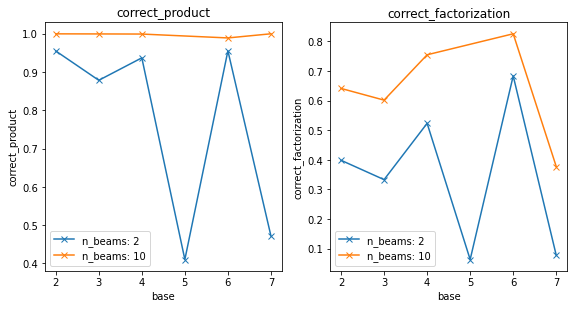

In [18]:
plot_crossed_values(metric_df, 'base', 'n_beams', metric_cols)

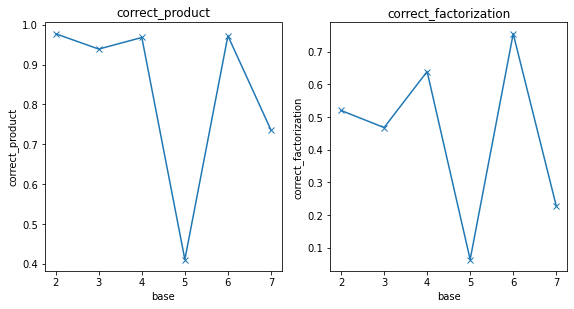

In [19]:
plot_single_value(metric_df, 'base', metric_cols)